# Описание и цель проекта:

Развлекательное приложение Procrastinate Pro+ несколько прошлых месяцев постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нужно изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей, с помощью расчета и анализа LTV, ROI, удержания и конверсии. 


***Цель исследования:*** 
- Причины неэффективности привлечения пользователей;
- Рекомендации для отдела маркетинга для повышения эффективности.


***Описание данных***
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Используемые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

## Обзор данных и подготовка их к анализу

In [2]:
#просмотр таблиц и информации о них

visits = pd.read_csv('/Users/polina/Downloads/visits_info_short.csv')
display(visits.head(3))
print(visits.info())
orders = pd.read_csv('/Users/polina/Downloads/orders_info_short.csv')
display(orders.head(3))
print(orders.info())
costs = pd.read_csv('/Users/polina/Downloads/costs_info_short.csv')
display(costs.head(3))
print(costs.info())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


In [3]:
# приведение названий столбцов с нижнему регистру, а пробелы заменяем на нижнее подчеркивание

visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = costs.columns.str.lower()

In [4]:
# замена типов данных в столбцах, где есть даты

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [5]:
# проверка на дубликаты
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


In [6]:
print(visits.info())
print(orders.info())
print(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage:

#### Вывод: 

1. В нашем распоряжении есть 3 таблицы: visits с данными о всех посещениях ресурса, orders со всеми покупками, costs с затратами на маркетинг. 
2. Были изменены названия столбцов. Все названия приведены к нижнему регистру, а пробелы заменены на нижнее подчеркивание. Это упростит дальнейшую работу с таблицами. 
3. Во всех таблицах в столбцах с датами изменены типы данных. Все столбцы приведены к типу данных datetime для возможности дальнейшей работы с датами. 
4. Дубликатов строк ни в одной таблице не обнаружено. 
5. Явные пропуски во всех таблицах отсутствуют. 

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

In [7]:
# расчет конверсии

def get_conversion(
    profiles,
    purchases, 
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return (
        result_raw,     # таблица с сырыми данными
        result_grouped,   # таблица конверсии
        result_in_time    # таблица динамики конверсии
    )

# расчет удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_ts <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

# Расчет LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_ts <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

# получение профиля пользователя

def get_profiles(sessions, orders, costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

# ф-ция для построения нужных нам графиков
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()
    
# граифик удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 
    
# построение графика конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


## Исследовательский анализ данных

In [8]:
# сортируем таблицу со всеми посещениями по пользователи и определяем дату его первого посещения

profiles = get_profiles(visits, orders, costs)
profiles.head(5)


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [9]:
# максимальная и минимлаьная даты привлечения пользователей

print(profiles['first_ts'].min())
print(profiles['first_ts'].max())

2019-05-01 00:00:41
2019-10-27 23:59:04


In [10]:
profiles_by_country = profiles.groupby('region').agg({'user_id': 'nunique'})
paying_profiles = profiles.query('payer == True')
paying_profiles_by_country = paying_profiles.groupby('region').agg({'user_id': 'nunique'})

profiles_by_country = profiles_by_country.merge(paying_profiles_by_country, on = 'region')
profiles_by_country.columns = ['all_users', 'paying_users']
profiles_by_country['conversion'] = profiles_by_country['paying_users'] / profiles_by_country['all_users'] * 100
display(profiles_by_country.sort_values(by = 'all_users', ascending = False))

,all_users,paying_users,conversion
region,,,
United States,100002,6902,6.901862
UK,17575,700,3.982930
France,17450,663,3.799427
Germany,14981,616,4.111875


In [11]:
profiles_by_device = profiles.groupby('device').agg({'user_id': 'nunique'})
paying_profiles = profiles.query('payer == True')
paying_profiles_by_device = paying_profiles.groupby('device').agg({'user_id': 'nunique'})

profiles_by_device = profiles_by_device.merge(paying_profiles_by_device, on = 'device')
profiles_by_device.columns = ['all_users', 'paying_users']
profiles_by_device['conversion'] = profiles_by_device['paying_users'] / profiles_by_device['all_users'] * 100
display(profiles_by_device.sort_values(by = 'all_users', ascending = False))

,all_users,paying_users,conversion
device,,,
iPhone,54479,3382,6.207897
Android,35032,2050,5.851793
PC,30455,1537,5.046790
Mac,30042,1912,6.364423


In [12]:
profiles_by_channel = profiles.groupby('channel').agg({'user_id': 'nunique'})
paying_profiles = profiles.query('payer == True')
paying_profiles_by_channel = paying_profiles.groupby('channel').agg({'user_id': 'nunique'})

profiles_by_channel = profiles_by_channel.merge(paying_profiles_by_channel, on = 'channel')
profiles_by_channel.columns = ['all_users', 'paying_users']
profiles_by_channel['conversion'] = profiles_by_channel['paying_users'] / profiles_by_channel['all_users'] * 100
display(profiles_by_channel.sort_values(by = 'all_users', ascending = False))

,all_users,paying_users,conversion
channel,,,
organic,56439,1160,2.055316
FaceBoom,29144,3557,12.204914
TipTop,19561,1878,9.600736
OppleCreativeMedia,8605,233,2.707728
LeapBob,8553,262,3.063253
WahooNetBanner,8553,453,5.296387
RocketSuperAds,4448,352,7.913669
MediaTornado,4364,156,3.574702
YRabbit,4312,165,3.826531


### Вывод: 

1. Был создан профиль каждого пользователя, в котором указана вся информация о пользователях из таблицы visits, и добавлены столбцы с датой первого посещения (с временем и без), месяц первого посещения, являлся ли пользователь покупателем, стоимость привлечения. 

2. По таблице с профилями мы можем сказать, что у анс есть данные о привлеченных пользователях с  1 мая 2019 по 27 октября 2019. 

3. Если рассматривать количество уникальных пользователей по странам, то  и в общем количестве пользователей, и в количестве платящих пользователей, и в проценте платящи хот всех лидирует США. США опережает следующую за ней Великобританию более чем в пять раз по всем пользвателям, и почти в 10 раз по платящим пользователям. В процентном соотношении платящих ко всем США не сильно всех опережает, разница между США и Францией, у которой самый маленький процент, всего около трех процентов. 

4. Если рассматривать количество уникальных пользователей в разбивке по устройству, с которого они заходили в первый раз, то по общему и платящему количеству пользователей лидирует Iphone, затем идет Android, у которого почти на 20 тысяч пользователей меньше, а платящих пользователей меньше на 1300 пользователей. Но в процентном соотношении Mac опережает Iphone на 0,1%. Но процентное отношение у всех устройств снова отличается не критично, разница между самым высоким процентом и самым низким около 1.3%. 

5. При рассмотрении источников, из которых ресурс получил пользователей, мы видим, что большинство пользователей органические, то есть самостоятельно нашли ресурс без какой-либо рекламы. Но количество платящих пользователей срезу них меньше, чем у следующего по популярности источника Faceboom. Это можно объяснить множеством факторов, например, грамотная реклама. Чаще пользователи переходят на ресурс, если их действительно заинтересовало какая-то конкретная услуга, описанная в рекламе. У источника Faceboom также и самый большой процент платящих пользователей. Разброс значений в случае разбивки по каналам привлечения уже больше, чем в предыдущих случаях. Он варьируется от 2,7% до 12,2%.  

## Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [13]:
# общие расходы

total_cost = costs['costs'].sum()
total_cost


105497.30000000002

In [14]:
cost_by_channel = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by = 'costs', ascending = False)
cost_by_channel

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


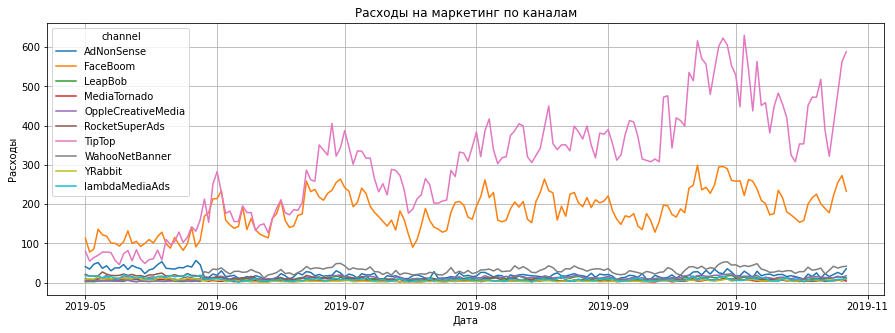

In [15]:
costs.pivot_table(index= 'dt',
                 columns = 'channel',
                 values = 'costs',
                 aggfunc = 'sum'
).plot(figsize = (15,5), grid = True)
plt.title('Расходы на маркетинг по каналам')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

In [16]:
# cac для всех неорганических пользователей
paid_profiles = profiles[profiles['channel'] != 'organic']
total_paid_users = paid_profiles['user_id'].count()
cac_total = total_cost / total_paid_users
cac_total

1.127481323942759

In [17]:
# cac для каждого источника трафика

cac_by_channel = cost_by_channel.merge(profiles_by_channel['all_users'], on= 'channel')
cac_by_channel['cac'] = cac_by_channel['costs'] / cac_by_channel['all_users']
cac_by_channel.sort_values(by = 'cac', ascending=False)

,costs,all_users,cac
channel,,,
TipTop,54751.30,19561,2.799003
FaceBoom,32445.60,29144,1.113286
AdNonSense,3911.25,3880,1.008054
lambdaMediaAds,1557.60,2149,0.724802
WahooNetBanner,5151.00,8553,0.602245
RocketSuperAds,1833.00,4448,0.412095
OppleCreativeMedia,2151.25,8605,0.250000
YRabbit,944.22,4312,0.218975
MediaTornado,954.48,4364,0.218717


#### Вывод: 

1. На маркетинговую кампанию в 10 источниках было потрачено суммарно 105497.3. Причем больше половины приходится на один канал привлечения, TipTop (54751). У него же и самый высокий показатель cac. Это значит, что пользователи из этого канала привлечения обходятся компании дороже всего. У второго по затратности канала привлечения FaceBoom (32445) показатель cac меньше. Поэтому он выгодней. Дешевле всего обходятся пользователи из канала LeapBob (0.2). Средний CAC для всех неорганический пользователей ~ 0.703. 
2. На графике временного распределения затрат на маркетинг, мы видим, что на TipTop тратилось больше всех остальных каналов большую часть наблюдения. Только в мае канал FaceBoom незначительно опережал его по этому показателю. Максимума траты на этот канал достигли к конце сентября-началу ноября. В это же время затраты на все остальные каналы привлечения значительно не менялись на протяжениив всего наблюдаемого времени. И находились в самом низу графика. 

## Окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Общая окупаемость рекламы

In [18]:
# расчет ltv и roi

result_raw, ltv_groupped, ltv_in_time, roi_groupped, roi_in_time = get_ltv( paid_profiles,
                                                                         orders,
                                                                         datetime(2019, 11, 1).date(),
                                                                         14,
                                                                        )

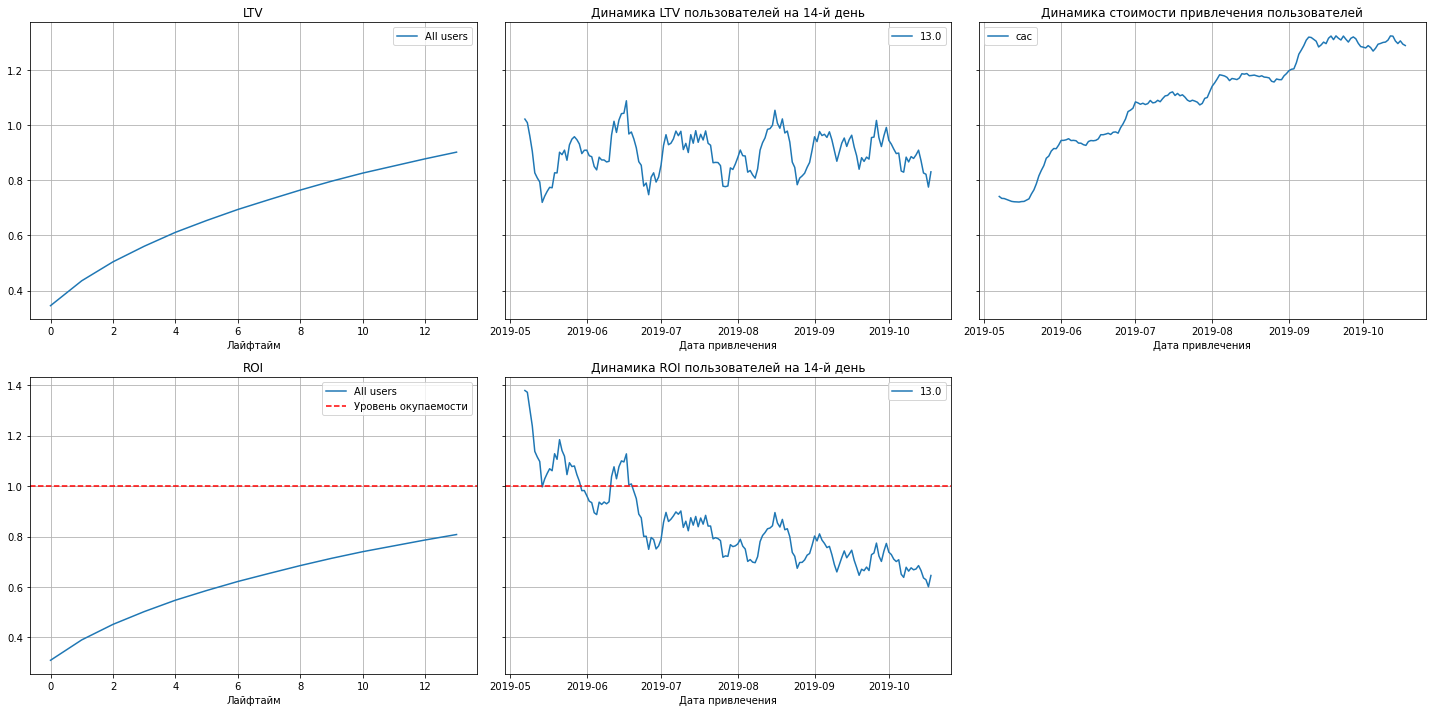

In [19]:
plot_ltv_roi(ltv_groupped, ltv_in_time, roi_groupped, roi_in_time, 14) 

### Окупаемость рекламы с разбивкой по устройствам

In [20]:
ltv_raw_dev, ltv_devices, ltv_history_devices, roi_devices, roi_history_devices = get_ltv( paid_profiles,
                                                                                      orders,
                                                                                      datetime(2019, 11, 1).date(),
                                                                                      14,
                                                                                      dimensions = ['device'])

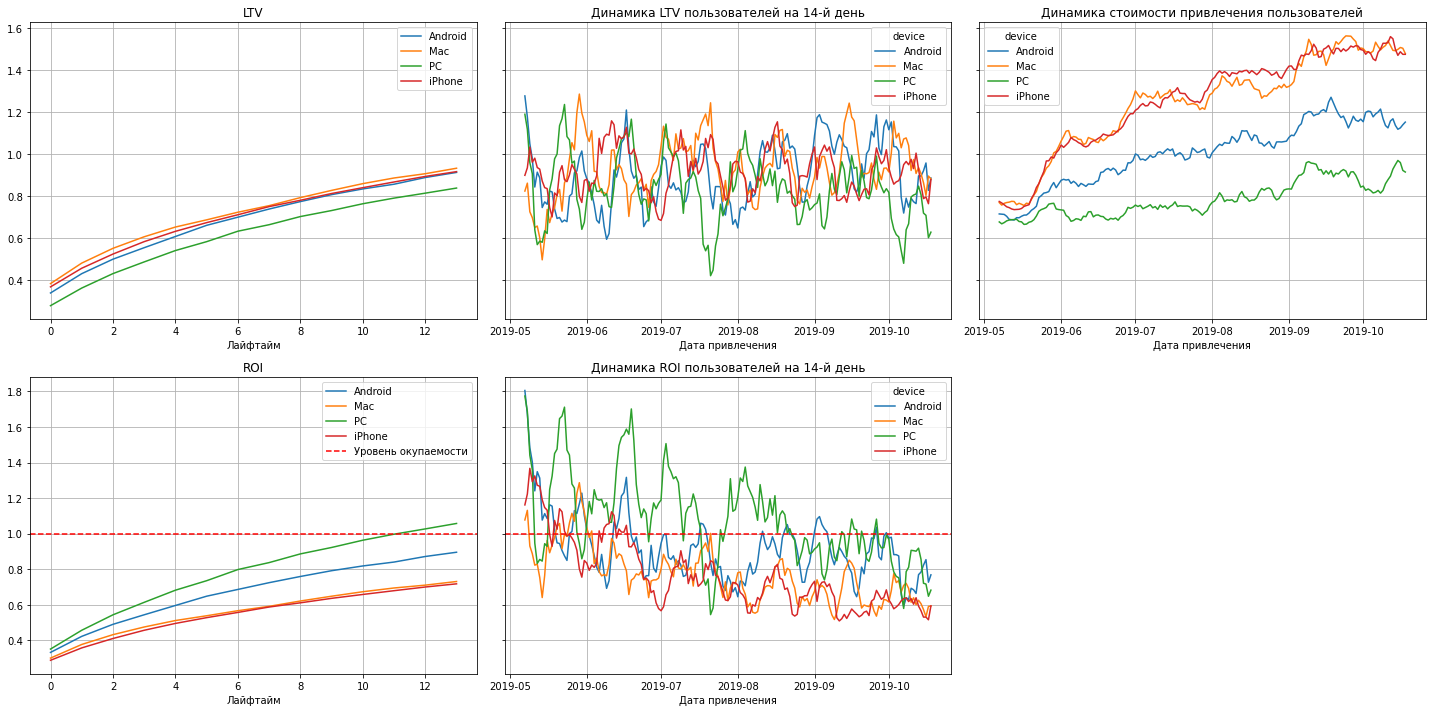

In [21]:
plot_ltv_roi(ltv_devices, ltv_history_devices, roi_devices, roi_history_devices, 14) 

### Окупаемость рекламы с разбивкой по странам

In [22]:
ltv_raw_countr, ltv_countries, ltv_history_countries, roi_countries, roi_history_countries = get_ltv( paid_profiles,
                                                                                      orders,
                                                                                      datetime(2019, 11, 1).date(),
                                                                                      14,
                                                                                      dimensions = ['region'])

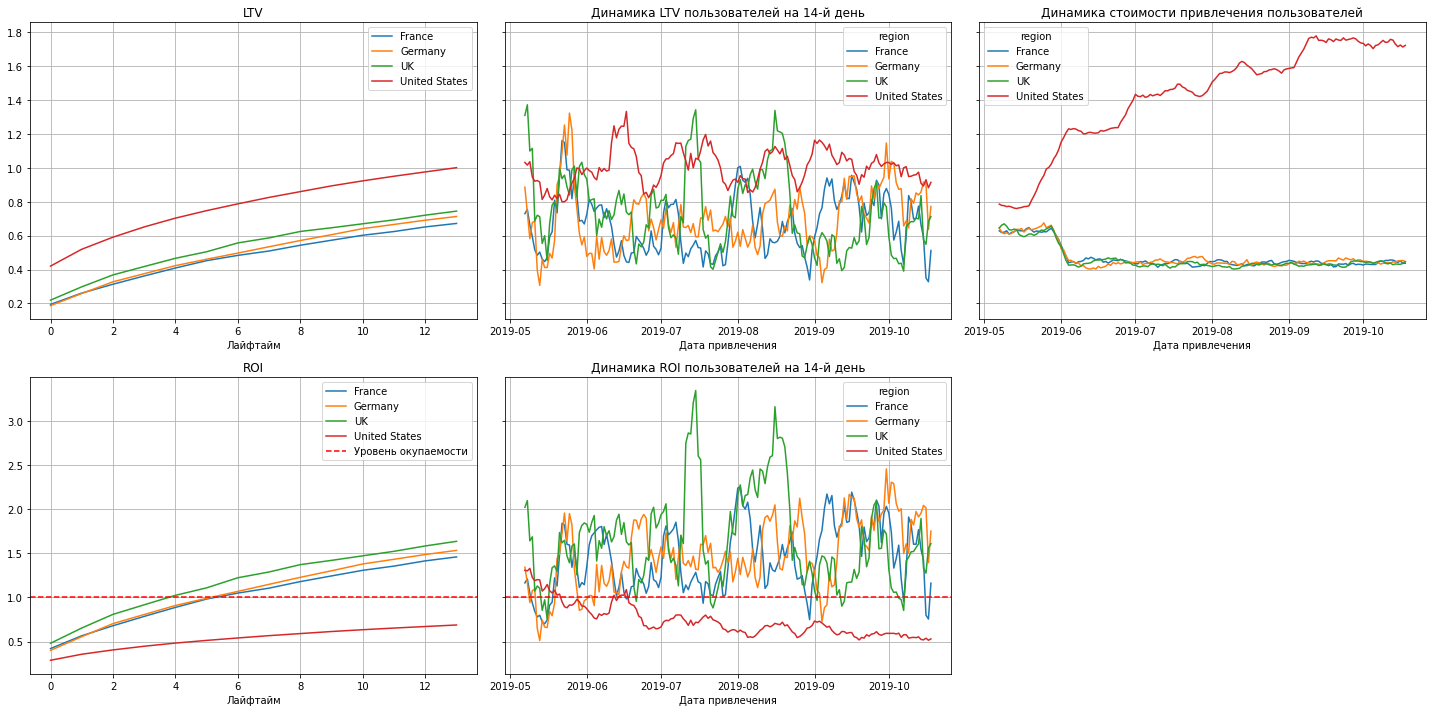

In [23]:
plot_ltv_roi(ltv_countries, ltv_history_countries, roi_countries, roi_history_countries, 14) 

### Окупаемость рекламы с разбивкой по рекламным каналам

In [24]:
ltv_raw_channel, ltv_channel, ltv_history_channel, roi_channel, roi_history_channel = get_ltv( paid_profiles,
                                                                                      orders,
                                                                                      datetime(2019, 11, 1).date(),
                                                                                      14,
                                                                                      dimensions = ['channel'])

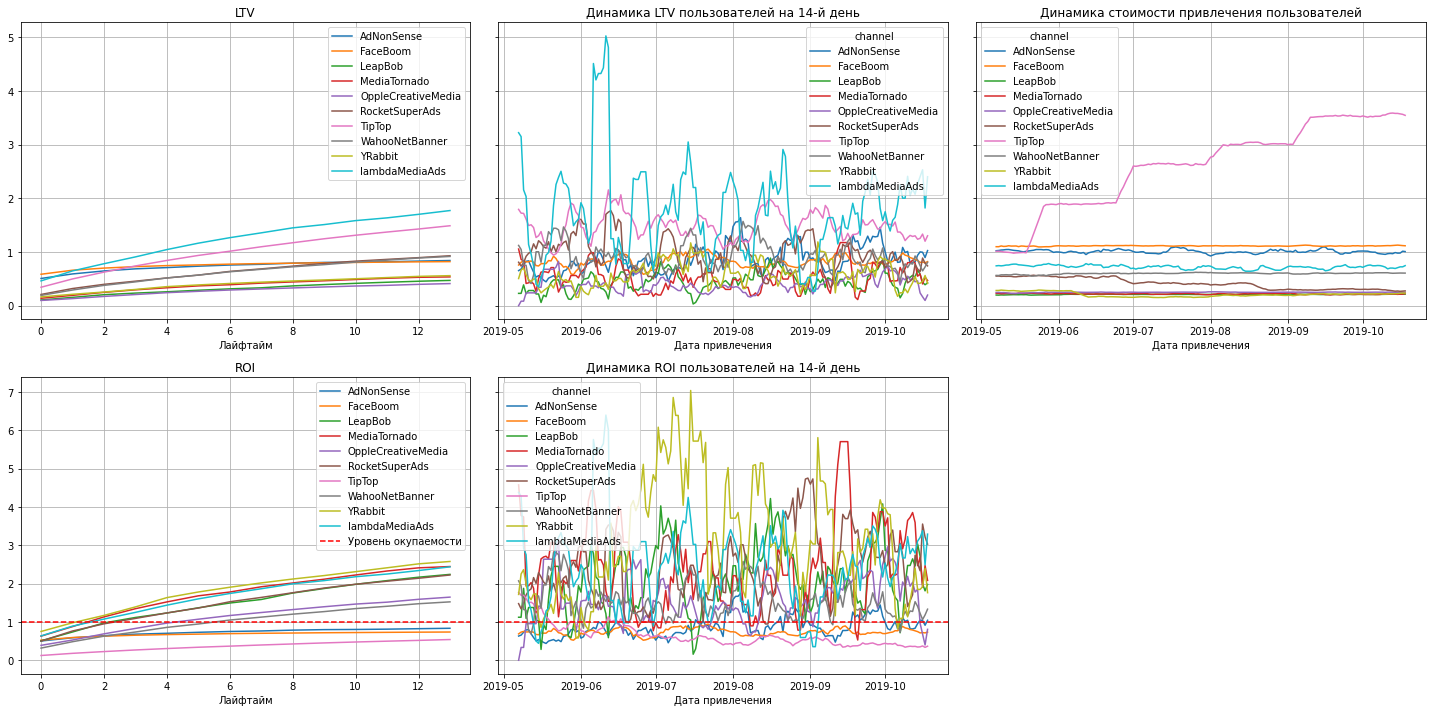

In [25]:
plot_ltv_roi(ltv_channel, ltv_history_channel, roi_channel, roi_history_channel, 14) 

#### Вывод: 

1. Был рассмотрен показатель ROI, то есть окупаемость затрат. Общий показатель ROI без разбивки на дополнительные критерии, показывает, что в среднем компания вплотную подошла к линии окупаемости, но пока все равно не пересекла. Если рассматривать ROI в динамике за май-октябрь, то видно, что в мае и июне затраты окупались, но этот показатель постоянно снижался.
2. Если рассатривать ROI с разбвкой по разным критериям, мы видим, что может снижать показатель окупаемости. Пользователи из США окупались только в мае, все остальное время они ниже планки окупаемости, хоть их и самое большое количество, а показатель LTV в США стабильно высокий. Все же затраты на их привлечение больше, чем прибыль. Пользвоатели из Соединеного Королевства, Франции и Германии окупаются в среднем на пятый день пользования продуктом. И с разбивкой по датам, эти страны в среднем окупались почти всегда. Несмотря на то, что LTV у этих стран ниже, чем у США, то есть пользователи приносят меньше денег, стоимость привлечения этих пользователей также намного ниже, поэтому окупаемость у Европейских стран выше. Вероятно, стоит больше сосредоточиться на Европейских покупателях, которые стабильно окупаются.
3. Что касается устройств пользователей, то по графикам видно, что пользователи mac и iphone и android в среднем не окупаются за 14 дней. Если рассмотреть показатели по месяцам, мы видим, что пользователи mac и iphone стабильно ниже планки окупаемости. А пользователи android только иногда превышвет планку окупаемости. Вероятная причина этого в том, что именно на этих устройствах приложение перестало корректно работать в июле, но по показателю LTV пользователи всех стройств стабильно находятся примерно на одном уровне. У android, mac и iphone нет провала в этом показателе. А стоимость привлечения пользователей у этих трех устройств выше, чем у PC. Соответсвенно, низкий руовень окупаемости.
4. Если рассматривать разбивку ROI по каналам привлечения пользователей, то мы видим, что самые низкие показатели у  TipTop. Не смотря на высокий показатель LTV у TipTop, у него и самый высокий CAC. Поэтому, в итоге, он не окупается. От этого канала привлечения, возможно, стоит отказаться, так как он стабильно убыточный. В неокупаемые каналы привлечения также попали FaceBoom, который шел на втором месте по затратам и показателю cac, и AdNonSense, который шел третьим. Все остальные каналы привлечения, несмотря на значительно меньшее количество привлеченных пользователей, оказались окупаемы. В лидерах по среднему общему LTV и среднему LTV по месяцам канал привлечения LambdaMediaAds. Особенно высокий показатель у этого канала привлечения в июне. Возможно, реклама в этом канале привлекает действительно целевых пользователей, и стоит увеличить объемы рекламы именно в них. 

### Графики удержания с разбивкой по устройствам

In [26]:
retention_raw, retention_groupped, retention_in_time = get_retention(profiles,
                                                                    orders,
                                                                    datetime(2019, 11, 1).date(),
                                                                    14,
                                                                    dimensions = ['device'],
                                                                    ignore_horizon=False,
                                                                    )


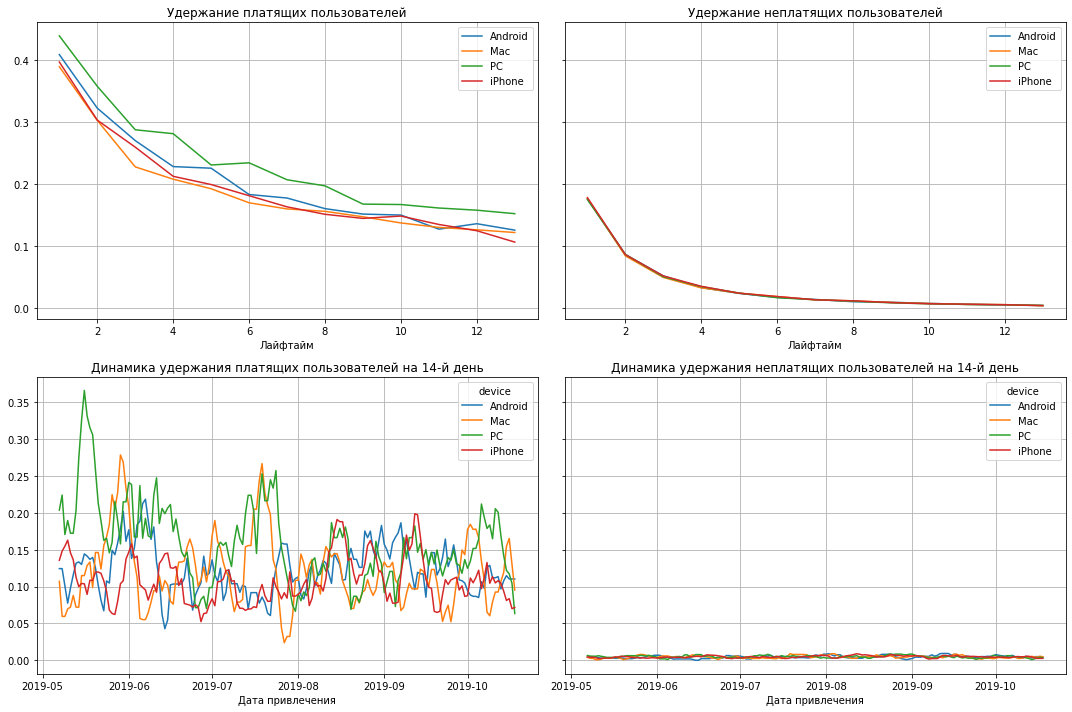

In [27]:
plot_retention(retention_groupped, retention_in_time, 14, window=7)


### Графики удержания с разбивкой по странам

In [28]:
retention_raw_regions, retention_regions, retention_in_time_regions = get_retention(profiles,
                                                                                    orders,
                                                                                    datetime(2019, 11, 1).date(),
                                                                                    14,
                                                                                    dimensions = ['region'],
                                                                                    ignore_horizon=False,
                                                                                    )

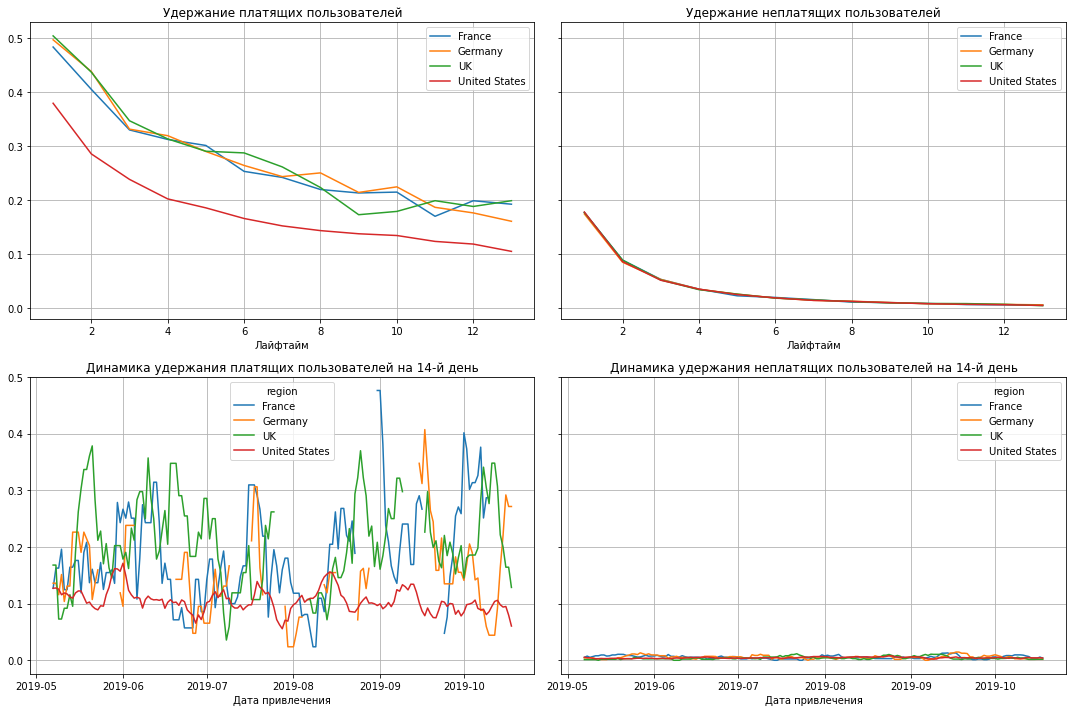

In [29]:
plot_retention(retention_regions, retention_in_time_regions, 14, window=7)

### Графики удержания с разбивкой по  рекламным каналам

In [30]:
retention_raw_channel, retention_channel, retention_in_time_channel = get_retention(profiles,
                                                                                    orders,
                                                                                    datetime(2019, 11, 1).date(),
                                                                                    14,
                                                                                    dimensions = ['channel'],
                                                                                    ignore_horizon=False,
                                                                                    )

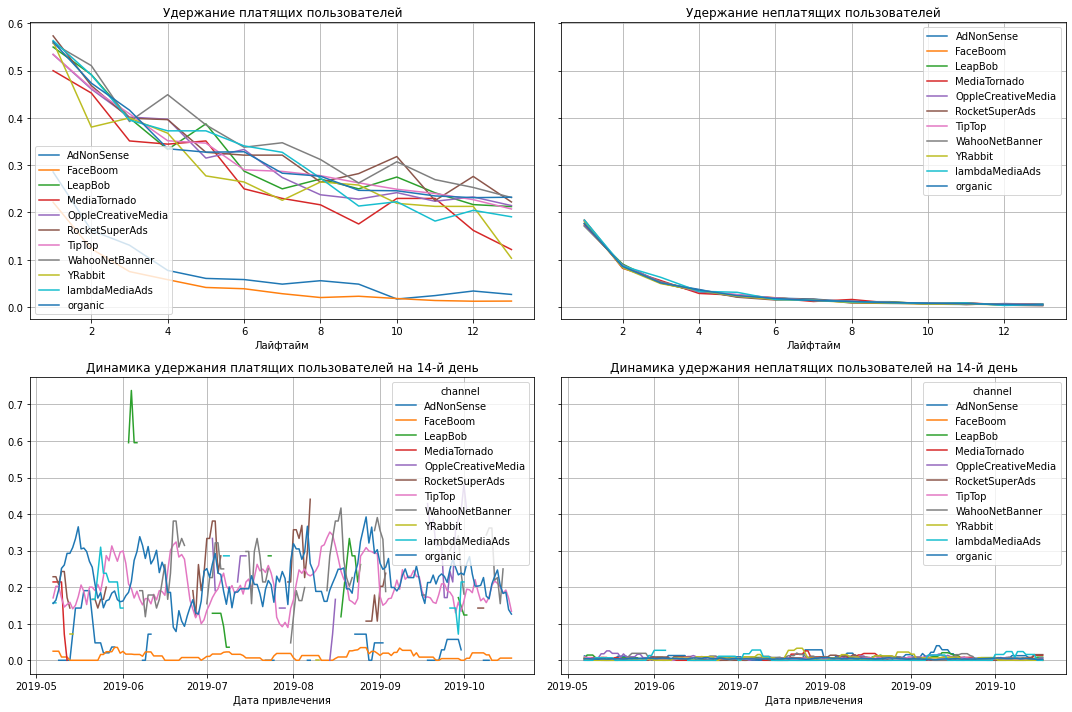

In [31]:
plot_retention(retention_channel, retention_in_time_channel, 14, window=7)

### Графики конверсии с разбивкой по устройствам

In [32]:
result_device, conversion_device, conversion_history_device = get_conversion(profiles,
                                                                             orders, 
                                                                             datetime(2019, 11, 1).date(),
                                                                             14,
                                                                             dimensions=['device'],
                                                                             ignore_horizon=False,
                                                                            )

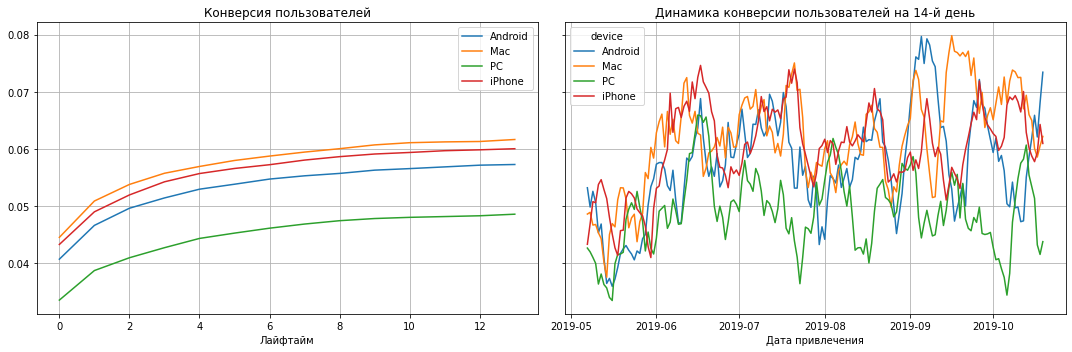

In [33]:
plot_conversion(conversion_device, conversion_history_device, 14, window=7)


### Графики конверсии с разбивкой по странам

In [34]:
result_country, conversion_country, conversion_history_country = get_conversion(profiles,
                                                                             orders, 
                                                                             datetime(2019, 11, 1).date(),
                                                                             14,
                                                                             dimensions=['region'],
                                                                             ignore_horizon=False,
                                                                            )

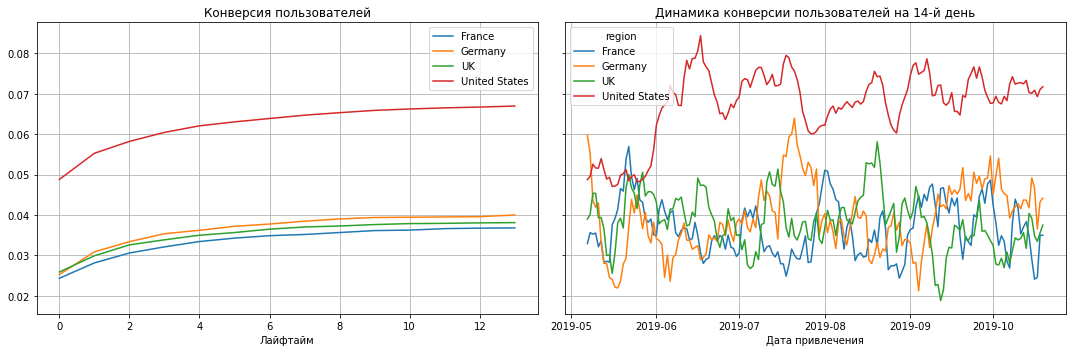

In [35]:
plot_conversion(conversion_country, conversion_history_country, 14, window=7)

### Графики конверсии с разбивкой по рекламным каналам

In [36]:
result_channel, conversion_channel, conversion_history_channel = get_conversion(profiles,
                                                                             orders, 
                                                                             datetime(2019, 11, 1).date(),
                                                                             14,
                                                                             dimensions=['channel'],
                                                                             ignore_horizon=False,
                                                                            )

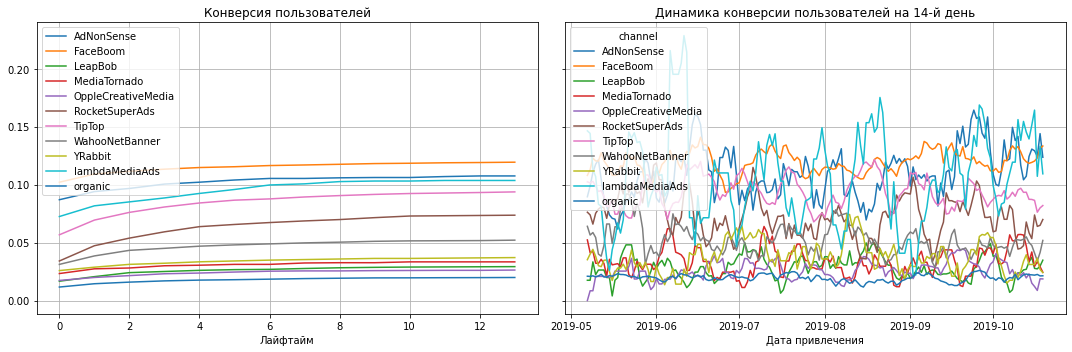

In [37]:
plot_conversion(conversion_channel, conversion_history_channel, 14, window=7)

#### Вывод: 

1. Все показатели удержания и конверсии проходят проверку их реалистичности. Все графики удержания пользователей убывают, а графики с неплатящими пользователями убывают быстрей платящих. А конверсия во всех случаях растет и не снижается. 
2. Показатели конверсии показывают процент пользователей ставших покупателями от общего числа пользователей. Таблицы с средними показателями уже были созданы и описаны исследовательском анализе данных. Также были созданы графики удержания пользователей, которые показывают, как долго пользователь остается с нашим приложением. Можно добавить, что показатели конверсии пользователей из США выше всех остальных стран, хоть они и не окупаются. Но показатели удержания у США самые низкие. Поэтому вероятней всего все-таки не надо бросать этот рынок, а работать над удержанием платящих пользователей. 
3. Также обстоит дело с конверсией и удержанием пользователей Mac и Iphone. У них высокие показатели конверсии на протяжении всего периода исследования. Но показатели удержания ниже, чем у всех остальных устройств. Поэтому версия о неисправности приложений для этих устройств все еще остается актальной. 
4. Что касается каналов привлечения, хуже всего конвертируются в покупателей органические пользователи. А самый большой показатель конвертации у FaceBoom, который, как мы уже выяснили, не окупается. Но показатель удержания пользователей у обоих каналов привлечения самые низкие. К 14 дню почти не остается платящих пользователей, пришедших из этих каналов. 

# Общий вывод:

1. Были составлены профили пользователей, в которых объеденена информация об их каналах привлечения, датах первого посещения, была ли хоть одна покупка, регион и стоимость привлечения этого пользователя. По всем этим показателям пользователи далее были разбиты по когортам и проводился анализ основных показателей: CAC, ROI, LTV, ocnversion rate, retention rate. 
2. Если рассматривать пользователей по их региону, то стоит более тщательно проработать рынок США, так как несмотря на самый высокий показатель количества пользователей и высокий LTV и конверсию, пользователи из США не окупаются. Они имеют низкий показатель удержания. Возможно, на рынке в этом регионе большая конкуренция, и пользователи переключаются на другие приложения в этой категории. Пользователи из Германии, Франции и Великобритании окупают свое привлечение, несмотря на более низкие показатели по всему, кроме удержания. 
3. Проаналировав каналы привлечения, мы знаем, что хуже всего конвертируются в покупателей органические пользователи. Но так как они бесплатные, компания не несет убытки от этого. Убыточными являются каналы TipTop, FaceBoom и AdNonSense. От этих каналов привлечения, возможно, стоит отказаться. Стоимость привлечения по этим каналам превышает доходы от этих пользователей. Хоть и каналы TipTop и FaceBoom приводят больше всего пользователей. Стоит вложить больше денег в рекламу во всех остальных каналах, которые пока что приносят меньше пользователей, но более качественных. 
4. Рассмотрев устройства пользователей, мы видим, что пользователи android, mac и iphone не окупаются, несмотря на то, что они стабильно лучше, чем пользователи PC конвертируются в покупателей. Но стоимость их привлечения значительно больше, чем PC. Возможно, эта проблема разрешится после отказа от убыточных каналов привлечения, потому что по показателям LTV, конверсия и удержание все утройства, включая PC, имеют примерно одинаковые показатели. Различие только в стоимости привлечения. 